
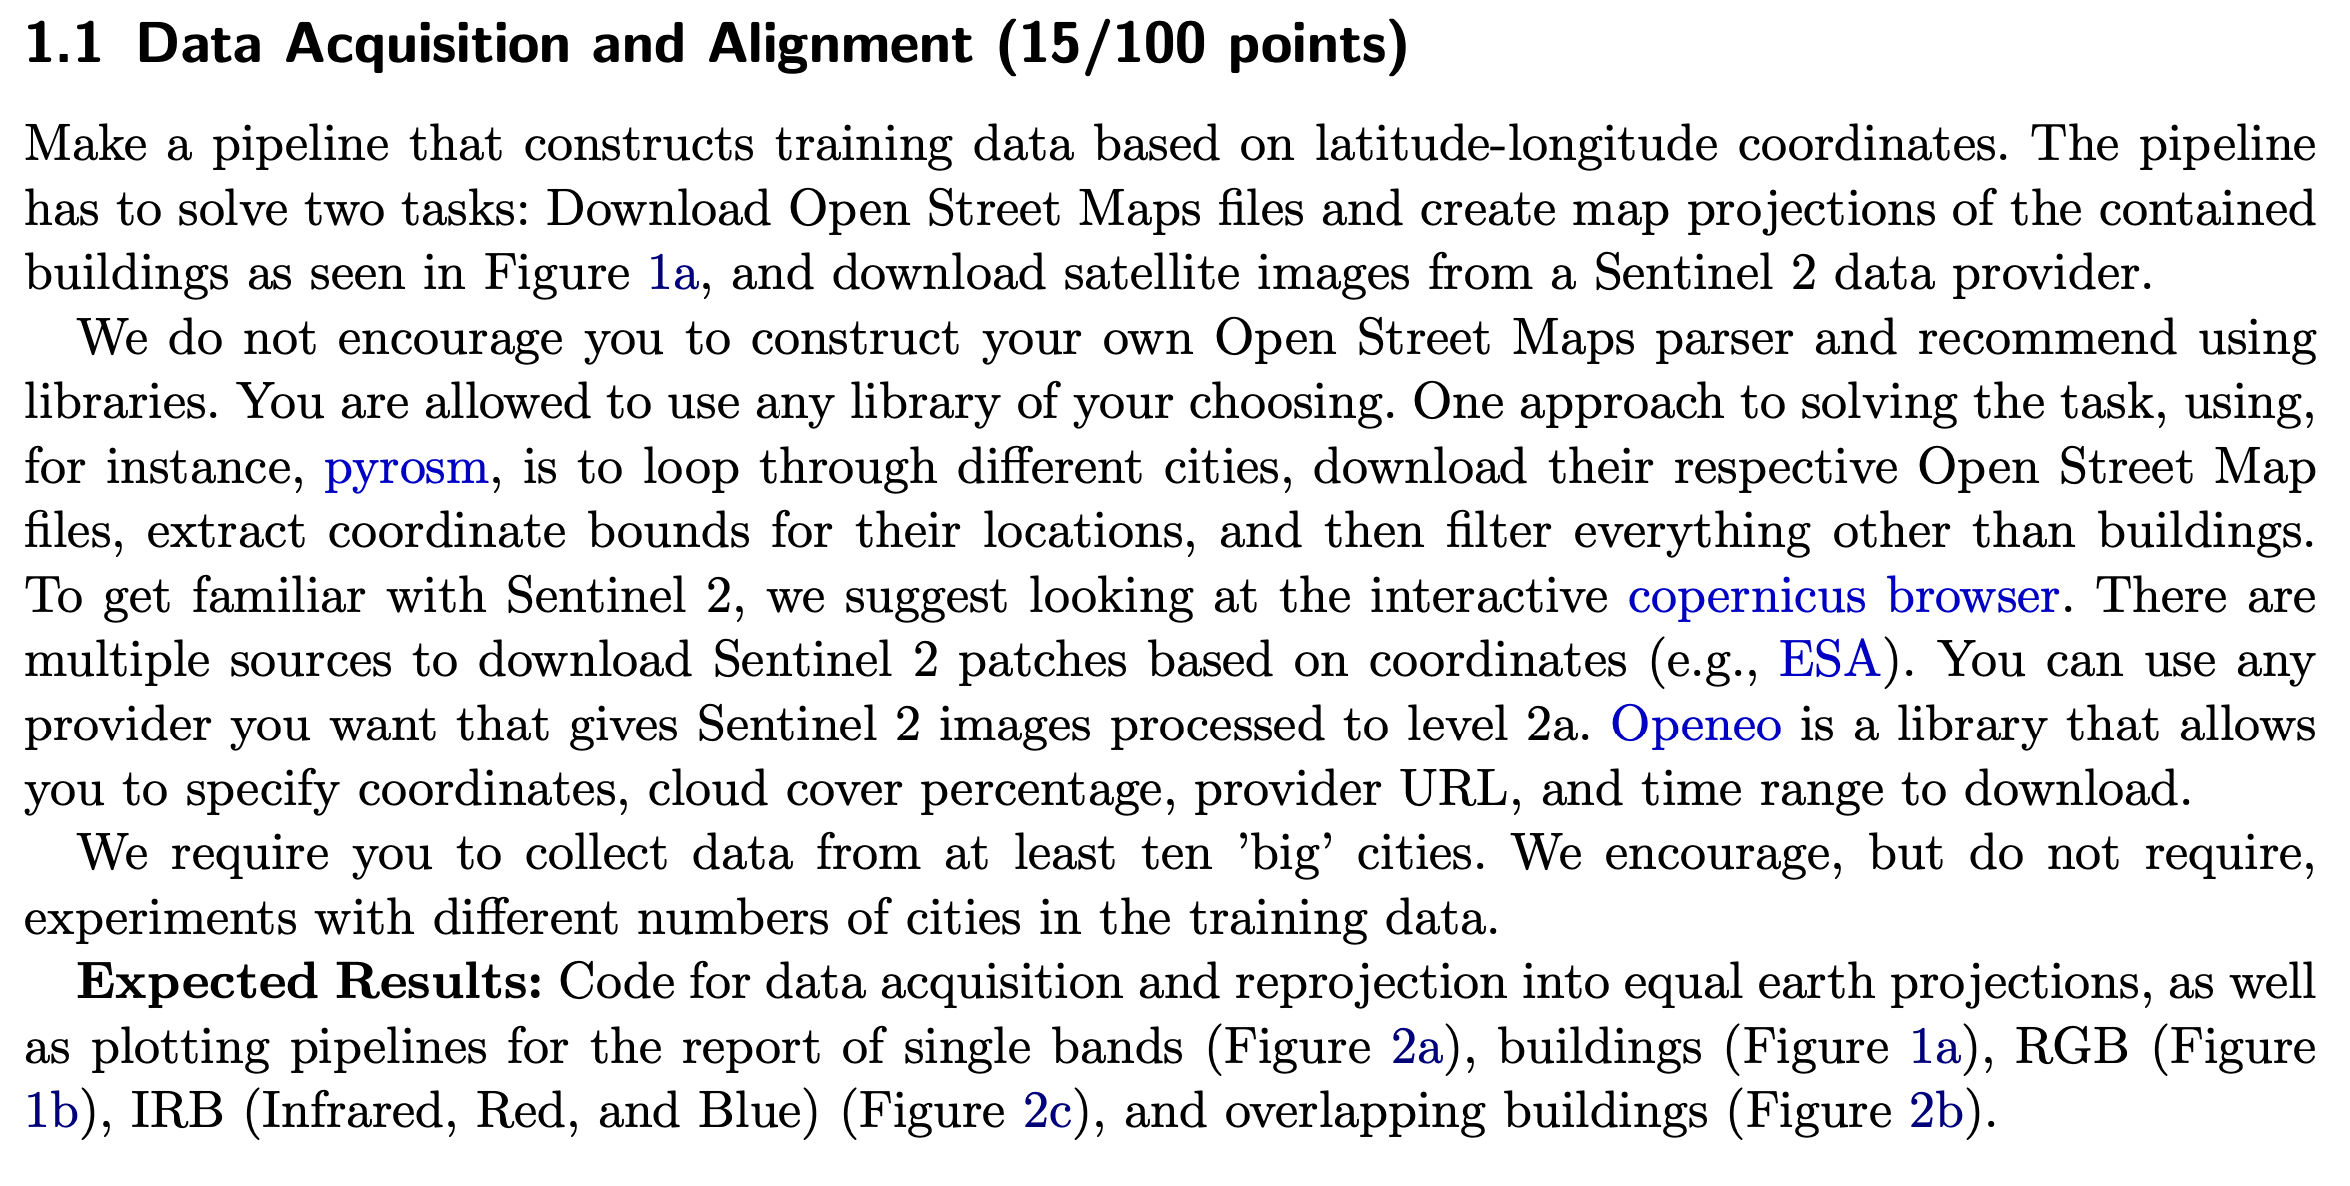

In [ ]:
# Data fetching
import pyrosm
import openeo

# Data storing
import os
from pathlib import Path
import xarray
import geopandas as gpd
import numpy as np
import torch

# Data handling
import matplotlib.pyplot as plt
import random
from pyproj import CRS
from PIL import Image
from rasterio.features import rasterize
import albumentations as A
from IPython.display import display
import cv2
import sklearn.feature_extraction.image

# Decorators
from decorators import timeit

In [ ]:
# Prepare local directories and file paths
resource_path = Path("ressources/")
resource_path.mkdir(parents=True, exist_ok=True)

osm_data_fp = resource_path / "osm_maps/"
osm_data_geometry_fp = resource_path / "osm_geometries"
osm_data_geometry_fp.mkdir(parents=True, exist_ok=True)
osm_data_fp.mkdir(parents=True, exist_ok=True)

sattelite_images = resource_path / "sattelite_images/"
sattelite_images.mkdir(parents=True, exist_ok=True)

dev_mode_osm_fp = osm_data_fp / "Berlin.osm.pbf"

dev_sat_img_fp = sattelite_images / "composite_sattelite_image.nc"

In [ ]:
class Config:
    # Sattelite Related
    sentinel_2_connection_id="SENTINEL2_L2A" # Sentinel data we are dealing with
    rgb_bands = ["B04", "B03", "B02", "SCL"] # Bands we are working with
    irb_bands = ["B08", "B04", "B02", "SCL"]
    all_bands = ["B04","B03", "B02", "B08", "SCL"]
    
    # OSM Related
    MIN_NUMBER_OF_CITIES = 1
    HANDPICKED_CITY_COORDS = [
    [-0.224136,51.425376,0.023057,51.547662],
    [37.502643,55.692206,37.737476,55.814364],
    [28.878773,40.982672,29.075326,41.078498],
    [2.250884,48.815576,2.428039,48.90637],
    [-3.795446,40.361223,-3.605588,40.48302],
    [-2.357444,53.420581,-2.140121,53.540919],
    [2.052497,41.317035,2.228355,41.467914],
    [12.459183,55.644274,12.637024,55.724790],
    [9.902096,53.515476,10.081997,53.605835],
    [20.910186,52.175346,21.097983,52.270619]
    ]
    city_coords = HANDPICKED_CITY_COORDS

    # Feel free to add cities to this list.
    HANDPICKED_CITIES = ["London", "Moscow", "Istanbul", "Paris", "Madrid", "Manchester",
              "Barcelona", "Copenhagen", "Hamburg", "Warsaw"]
    cities = HANDPICKED_CITIES 
    
    # Training Related
    patch_size = 32
    channel_amount = 4 # TODO shouldn't this be 4?
    
    # Coordinate related W, S, E, N (min lng, min lat, max lng, max lat)
    height = 2048 # Default Resolution in the y direction
    width = 2048 # Default Resolution in the x direction
    accuracy_test_coordinates = [13.294333, 52.454927, 13.500205, 52.574409] # Berlin test data coordinates

    # epsg references
    # TODO find the right ones
    osm_ref = "EPSG:4326"
        
config = Config()

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# OpenStreetMaps Data:
- Download the city files
- Save relevant information in a format that is quick to access
- Project into proper coordinates
- Rasterize the polygons into pixel related information

In [ ]:
class OSMDataLoader:
    
    def __call__(self, city_name: str, bounding_box: list, projected_bbox: list, epsg: CRS,
                 plotResults=False, s2=None, update=False, height=config.height, width=config.width):
        '''
        Downloads, Fetches and processes OSM data for one city
        Input:
            city_name: Name of city we want to operate on
            bounding_box: bounding box of extracted geometry in angles
            projected_bbox: bounding box of extracted geometry in projected coordinates
            epsg: projected coordinates reference system
            plot: whether to plot the results (for debugging) or not
            update: whether to update the local data or not
        Output:
            Numpy array of OSM buildings data
        '''
        # Make sure everything is downloaded
        fp = self.download_city_data(city_name, bounding_box,update)
        # Get the data
        buildings = self.get_buildings(fp)
        #Plot before the projection, can also be done afterwards obviously
        if(plotResults):
            fig, ax = plt.subplots(figsize=(12, 8))
            plt.axis('off')
            plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Removes padding
            plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Removes padding
            buildings.plot(ax=ax)
            
        buildings = buildings.to_crs(epsg)
        # Rasterizing the data
        rasterized_buildings = self.rasterize_osm(buildings, projected_bbox,height, width)
        # Plotting
        if(plotResults):
            self.plot(rasterized_buildings)
            if not s2 is None:
                self.plot_city_background(s2, buildings)
        
        return rasterized_buildings
        
    def download_city_data(self, city_name: str, bounding_box: list, update=False):
        '''
        Downloads the OSM data file for the corrosponding city, saves the file as a gometry folder for
        ease of access, returns the folder path for it.
        Input:
            city_name: Name of the city
            bounding_box: List of WSEN EPSG:4326 Coordinates to extract buildings from and save
            update: whether we update the original .pbf datafile
        Output:
            Filepath for the downloaded file
        '''
        osm_city_local_file_path = osm_data_fp / str(city_name + ".osm.pbf")
        # If the file exists in ressources no need to download it again.
        fp = str(osm_city_local_file_path) if os.path.isfile(osm_city_local_file_path) else False
        # only downloading if the file doesn't already exist in backend
        if not fp:
            fp = pyrosm.get_data(city_name, directory=osm_data_fp)
            
        osm_city_local_geometry_file_path = str(osm_data_geometry_fp) + "/" + str(city_name)
        if update:
            print(f"Deleting the current shapefile for {city_name}")
            # Remove the previous geometry folder
            os.rmdir(osm_city_local_geometry_file_path)
            
        # Save the geometry as a shapefile
        if not os.path.isdir(osm_city_local_geometry_file_path):
            print(f"Saving data for {city_name} as a shapefile...")
            osm = pyrosm.OSM(fp, bounding_box)
            # Get the geometry
            geom = osm.get_buildings().geometry
            # Filter out things that are not buildings in the geometry
            geom = geom.loc[geom.geometry.geometry.type.isin(['MultiPolygon','Polygon'])]
            geom.to_file(osm_city_local_geometry_file_path)
            
        return osm_city_local_geometry_file_path
    
    @timeit
    def get_buildings(self, city_geometry_data_fp: Path):
        '''
        Read the shape file and get the geometry of the buildings as a dataframe
        Input:
            city_geometry_data_fp
        Output:
            GeoDataFrame containing bulding geometry
        '''
        if os.path.isdir(city_geometry_data_fp):
            return gpd.GeoDataFrame.from_file(city_geometry_data_fp)
        else:
            print(f"Folder {city_geometry_data_fp} not found")
    @timeit        
    def rasterize_osm(self, buildings: gpd.GeoDataFrame, coords: list, height, width):
        '''
        Turn the geopandas dataset into a numpy array, 1 where there are buildings, 0 where there is not
        Input:
            buildings: Geometry dataframe to rasterize
            coords: coordinates bounding box that the dataframe uses (Projected in this case)
            width: Width of output image
            height: Height of output image  
        Output:
            Numpy array of shape [height, width,1] indicating buildings per pixel
        '''
        xres = (coords[2] - coords[0]) / width
        yres = (coords[3] - coords[1]) / height
        # Affine transformation
        #| x' |   | a  b  c | | x |
        #| y' | = | d  e  f | | y |
        #| 1  |   | 0  0  1 | | 1 |
        return rasterize(shapes=buildings.geometry,
                         out_shape=(height, width),
                         transform=(xres, 0, coords[0], 0, -yres, coords[3]))[:,:,None]
    
    def plot(self, img: np.ndarray):
        fig = plt.figure(figsize=(12,8))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.show()
        
    @timeit   
    def plot_city_background(self, s2, osm):
        fig, ax = plt.subplots(figsize=(12, 8))
        plt.axis('off')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Removes padding
        plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Removes padding
        s2[0:3].plot.imshow(vmin=500, vmax=2000, ax=ax)
        osm.plot(ax=ax, color='cornflowerblue')
        
osmDataLoader = OSMDataLoader()

# Sentinel 2 Data fetching:
- Download Images in different bands, with cloud coverage and temporal extent specified.
- Pick an appropriate image
- Extract what coordinate system we are working in

In [ ]:
class SentinelDataLoader():
    
    def __call__(self, city_name: str, coords: list, bands: list,
                 start_date = "2023-04-01", end_date = "2023-08-30", mask = True, plotResults = False):
        '''
        Downloads, fetches and processes Sentinel 2 sattelite data for one city
        Input:
            city_name: Name of the city we are operating on
            coords: Which coordinates we extract our images from
            bands: Which bands we operate on
            start_data -> end_data: Temporal extent of the potential data we fetch
            mask: Whether to mask clouds or sample the least cloudy day
            plot: Whether to plot results or not
        Output:
            dataArray of the S2 sattelite data
            epsg coordinate reference system of the returned data
            extracted bounded box from the returned data
        '''     
        # Collect data depending on which approach we prefer
        if mask:
            s2, epsg = self.get_masked_data(city_name, coords, bands)
        else:
            s2, epsg = self.get_least_cloudy_data(city_name, coords ,bands)
        # Extract coordinates
        extracted_coords = self.get_coordinates_from_sattelite_dataArr(s2)
        #Plot
        if plotResults:
            self.plot(s2)
        
        return s2, extracted_coords, epsg
    
    @timeit
    def get_masked_data(self, city_name: str, coords: list, bands: list,
                        start_date = "2023-04-01", end_date = "2023-08-30", grey=False):
        '''
        Get a sattelite image of the given city with the given bands.
        If there are clouds, we resample again for a cloudless version for those specific pixels.
        Input:
            city_name: Name of the city we are operating on
            coords: Which coordinates we extract our images from
            bands: Which bands we operate on
            start_data -> end_date: timespan we consider taking images from
        Output:
            Xarray.DataArray of values of each Band according to our bounding box.
            epsg coordinate reference system of the current image
        '''
        connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
        connection.authenticate_oidc() 
        # Make sure we are connected
            
        city = city_name + "_masked"
        sattelite_img_fp = sattelite_images / str(city + ".nc")

        if not os.path.isfile(sattelite_img_fp):
            # Prepare the Query (Summer/Spring months, Long periods are preferred, low cloud coverage)
            s2_cube = connection.load_collection(
                "SENTINEL2_L2A",
                temporal_extent=(start_date, end_date),
                spatial_extent=self.get_spatial_extent(coords),
                bands=config.all_bands,
                max_cloud_cover=30,
            )
            # Mark which band we are using for masking
            scl_band = s2_cube.band("SCL")
            # Mask which pixel values we want replaced
            cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)
            # Resample the resolution (because SCL is 20m res, not 10, it may create artifacts if we dont do this)
            cloud_mask = cloud_mask.resample_cube_spatial(s2_cube)
            # Mask our query and get the mean values
            composite_masked = s2_cube.mask(cloud_mask).mean_time()
            
            if grey:
                composite_masked = composite_masked.mean

            print(f"Saving a masked version of {city_name} locally.")
            composite_masked.download(outputfile=sattelite_img_fp)

        ds = xarray.load_dataset(sattelite_img_fp)
        epsg_code = CRS.from_cf(ds.crs.attrs)
        # Convert xarray DataSet to a (bands, x, y) DataArray
        return ds[bands].to_array(dim="bands"), epsg_code
    
    @timeit
    def get_least_cloudy_data(self, city_name: str, coords: list, bands: list,
                              start_date = "2023-08-01", end_date = "2023-09-30"):
        '''
        Get a sattelite image of the given city with the given bands.
        We iterate through the entire time period and pick the image with the least cloud coverage
        Input:
            city_name: Name of the city we are operating on
            coords: Which coordinates we extract our images from
            bands: Which bands we operate on
            start_data -> end_date: timespan we consider taking images from
        Output:
            Xarray.DataArray of values of each Band according to our bounding box.
            epsg coordinate reference system of the current image
        '''
        connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
        # Make sure we are connected
        connection.authenticate_oidc() 
            
        city = city_name + "_temporal"
        sattelite_img_fp = sattelite_images / str(city + ".nc")

        if not os.path.isfile(sattelite_img_fp):
            # Prepare the Query (Summer/Spring months, short periods are acceptable , any cloud coverage)
            s2_cube = connection.load_collection(
            "SENTINEL2_L2A",
            temporal_extent=(start_date, end_date),
            spatial_extent=self.get_spatial_extent(coords),
            bands=config.all_bands,
            max_cloud_cover=50,
            )

            print(f"Saving a temporal version of {city_name} locally.")
            s2_cube.download(outputfile=sattelite_img_fp)

        ds = xarray.load_dataset(sattelite_img_fp)
        epsg_code = CRS.from_cf(ds.crs.attrs)
        # Convert to Data array
        time_data = ds[bands+["SCL"]].to_array(dim="bands")
        # Variables to save least cloudy day
        min_clouds = float('inf')
        min_index = 0

        for i,inst in enumerate(time_data[3]):
            # Count SCL classes
            indices,counts = np.unique(inst.data,return_counts=True)

            curr = dict(zip(indices, counts))
            # Count cloudy pixels
            cld_small = curr.get(8)
            cld_big = curr.get(9)
            cld_shadow = curr.get(3)
            # Sum up cloudy pixels
            curr_clouds= cld_small if cld_small else 0 + cld_big if cld_big else 0 + cld_shadow if cld_shadow else 0
            # Save minimum cloudyness
            if(curr_clouds<min_clouds):
                min_clouds=curr_clouds
                min_index=i
            # if its not cloudy we immediately take it
            if(min_clouds==0): break
        # Save least cloudy day
        return time_data[:,i,...],epsg_code
    
    def get_spatial_extent(self, bounding_box: list):
        '''
        Convert bounding box to a dictionary
        '''
        spatial_extent = {
            "west": bounding_box[0], 
            "south": bounding_box[1], 
            "east": bounding_box[2], 
            "north": bounding_box[3],
        }
        return spatial_extent
    
    def get_coordinates_from_sattelite_dataArr(self, dataArr: xarray.DataArray):
        '''
        Takes in a dataArray and returns a bounding box according to its min and max coordinates
        Input:
            dataArr: The dataArray we want to extract from
        Output:
            List as a WSEN coordinates
        '''
        # Assign the coordinates
        coordinates_x, coordinates_y = dataArr.x, dataArr.y
        # Extract the boundary
        east_boundary = coordinates_x.min().values
        west_boundary = coordinates_x.max().values
        south_boundary = coordinates_y.min().values
        north_boundary = coordinates_y.max().values

        return [east_boundary, south_boundary, west_boundary, north_boundary]
    
    def plot(self, data: xarray.DataArray, vmin=0, vmax=2000):
        fig, ax = plt.subplots(figsize=(10, 8))
        plt.axis('off')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())  # Removes padding
        plt.gca().yaxis.set_major_locator(plt.NullLocator())  # Removes padding
        
        if len(data.bands) == 3:
            data.plot.imshow(vmin=vmin, vmax=vmax, ax=ax)
        else:
            data[:-1].plot.imshow(vmin=vmin, vmax=vmax, ax=ax)
            
s2DataLoader = SentinelDataLoader()

### Download all the data (this only needs to be run once)

In [ ]:
for coord, name in zip(config.city_coords,config.cities):
    # Fetching data
    __ ,projected_coords, epsg = s2DataLoader(name, coord, config.all_bands)
    __ = osmDataLoader.download_city_data(name, coord)

## Visual Example of Pipeline:
- Plotting Sattelite data in different bands
- Plotting OSM data
- Plotting OSM data after rasterization

#### TODO: single band

In [ ]:
# Which City to Display, set to -1 to disable
EXAMPLE_CITY = 0
coord = config.accuracy_test_coordinates
name = "Berlin"

# Displaying Process
if EXAMPLE_CITY!=-1:
    s2, projected_coords, epsg = s2DataLoader(name, coord, config.all_bands, plotResults=True)
    __, __, __ = s2DataLoader(name, coord, config.rgb_bands, plotResults=True)
    __, __, __ = s2DataLoader(name, coord, config.irb_bands, plotResults=True)
    x, __, __ = s2DataLoader(name, coord, ['B04'])
    # Plot singular band as well but first we have to duplicate the band 3 times over
    grey = xarray.concat((x,x,x), dim='bands')
    s2DataLoader.plot(grey,vmin=200)

In [ ]:
if EXAMPLE_CITY!=-1:
    __ = osmDataLoader(name, coord, projected_coords, epsg, plotResults=True, s2=grey)

## Expected Results:
Code for data acquisition and reprojection into equal earth projections, as well as plotting pipelines for the report of single bands , buildings,  RGB , IRB (Infrared, Red, and Blue) , and overlapping buildings.

## 1.2 Data Preparation
- Sattelite images from Task 1.1 are given in an xarray Dataset of shape [Bands, Height, Width] per image, but also associated with it are variable spatial coordinates.
    - Bands dictating which bands we used
    - X dictating the spatial longitude coordinates of our PixelX
    - Y dictating the spatial latitude coordinates of our PixelY
- Osm data are given as a 2d raster numpy array (pixel_x, pixel_y)

#### Task:
1. Given the pipeline from Task 1.1, prepare the large images for training by slicing out tensors containing smaller training images of equal width and height, for instance, 32, 64, or 128 pixels

2.  include in the pipeline a simple cloud-cover classifier and remove all patches containing clouds.

3. Divide the data into train/validation/test sets of similar data distributions (e.g., label distribution and potentially other properties such as visual similarity or data provenance
- Possible convert into Numpy for ease of use and acceleration

In [ ]:
class PreProcess():
    
    def __call__(self, s2_data: np.ndarray, osm_data: np.ndarray, res_of_patch=config.patch_size, mode="Grid", max_patch=1000,
                 precent=0.02, plotResults=False):
        '''
        Go through the entire pipeline of preprocessing
        1. Convert to numpy
        2. Patch data
        3. Remove clouds
        4. Plot
        Input:
            s2_data: Sattelite image
            osm_data: osm numpy array related to our image
            res_of_patch: resolution of patches we will extract
            mode: Mode of patch extraction
            max_patches: max number of patches to extract (only valid for Random mode)
            precent: tolertable cloud precentage
            plotResults: Plot every step of the process or not
        Output:
            PreProcessed training images and target images for one city
        '''
        # Convert to numpy
        s2_np = self.xarr_to_np(s2_data)
        
        # Slice the combined version and the raw version
        sliced_s2 = self.patch_arr(s2_np, res=res_of_patch, mode=mode, max_patch=max_patch)
        sliced_combined = self.patch_arr(osm_data, res=res_of_patch, mode=mode, max_patch=max_patch)
        
        # Remove cloudy patches
        cloudless_s2, cloudless_osm ,num_of_removed = self.remove_clouds(sliced_s2,sliced_combined, precent)
        
        if plotResults:
            # Plot
            fig = plt.figure(figsize=(15, 15), layout='tight')
            fig.add_subplot(2, 2, 1)
            self.plot(s2_np)
            fig.add_subplot(2, 2, 2)
            self.plot(osm_data)
            fig.add_subplot(2, 2, 3)
            combined = self.combine_sattelite_with_osm_buildings(s2_np, osm_data)
            self.plot(combined)
            
            self.plot_patches(sliced_s2)
            self.plot_patches(sliced_combined)
            
            if num_of_removed>0:
                print(f"Removed {num_of_removed} cloudy patches")
        return (cloudless_s2, cloudless_osm)
    
    @timeit
    def xarr_to_np(self, data: xarray.DataArray):
        '''
        Convert the data array [Bands,x,y] to a numpy array [height,width,bands]
        Use RGB values for normalization + plotting instead of luminance.
        Input:
            data: dataArray containing sattelite images
        Output:
            numpy converted array
        '''
        # reorganizing dimensions
        new_data = np.zeros((data.shape[1],data.shape[2],data.shape[0]))
        for i in range(data.shape[0]):
            new_data[:,:,i] = data[i,:,:]

        # Removal of negative values
        min_v = new_data.min()
        new_data += abs(min_v) if min_v<0 else 0 
        # Removal of outlier values
        # This is done implicitly in dataArray.plot.imshow but not in npArr.imshow
        p_2, p_98 = np.percentile(new_data, (2, 98))
        new_data = np.clip(new_data, p_2, p_98)
        # Normalization according to our new min and max
        new_data = (new_data - p_2) / (p_98 - p_2)
        
        return new_data
    
    @timeit
    def patch_arr(self, data: np.ndarray, res: int, mode: str, max_patch: int):
        '''
        Divide the image into small patches of a given resolution
        Either divide the patches in a grid or extract random patches
        Input:
            data: The data we are extracting the patches from
            res: Resolution of patches
            mode: "Grid" or "Random" to decide the algorithm
            max_patch: number of patches to extract if we choose random selection
        Output:
            Numpy array of shape [Num of Patches, Resolution of patch, Resolution of patch, bands]
        '''
        if mode=="Grid":

            # Generate patches from a regular grid
            min_w = data.shape[0]
            min_h = data.shape[1]
            # Crop edges of patches due to projection errors
            crop_w = int(0.05 * data.shape[0])
            crop_h = int(0.05 * data.shape[1])
            min_w -= crop_w
            min_h -= crop_h
            
            data = data[crop_w:min_w, crop_h:min_h]

            min_w -= crop_w
            min_h -= crop_h
            # If the length dimension does not match a regular subdivision of grids, clip the start of it
            if(min_w%res!=0):
                min_w -= int(min_w - np.floor(min_w/res)*res)
            # If the width dimension does not match a regular subdivision of grids, clip the start of it
            if(min_h%res!=0):
                min_h -= int(min_h - np.floor(min_h/res)*res)
            data = data[:min_w,:min_h]
            return data.reshape((min_w//res,
                                 res,
                                 min_h//res,
                                 res,-1)).transpose(0,2,1,3,4).reshape(-1,res,res,data.shape[2])

        if mode=="Random":
            # Randomly crop out patches from the image (Only supported for np arrays)
            return sklearn.feature_extraction.image.extract_patches_2d(data,
                                                                       (res,res),max_patches=max_patch, random_state=0)
    
    @timeit
    def remove_clouds(self, data: np.ndarray, osm: np.ndarray, precent: float):
        '''
        Iterate over all patches and check if theyre too cloudy and remove them.
        Mostly used if we dont choose the masking operation when extracting images
        Input:
            data: patched data we are operating on
            osm: associated OSM data
            precent: what Precentage of cloud coverage are we willing to tolerate
        Output:
            patched data array without cloudy patches
        '''
        n=data.shape[0]
        for i in range(n):
            if(i==data.shape[0]): break
            if self.detect_cloud_patch(data[i,:,:,-1],precent):
                data = np.delete(data,i,axis=0)
                osm = np.delete(osm,i,axis=0)
        return (data[:,:,:,:-1], osm ,n - data.shape[0])
    
    def detect_cloud_patch(self,img: np.ndarray ,precent: float):
        '''
        Detect cloudyness of one image/patch
        Input:
            img: image we are operating on
            precent: what Precentage of cloud coverage are we willing to tolerate
        Output:
            True if the image is too cloudy, false otherwise
        '''
        p = (np.where((img==1) + (img==2) + (img==8) + (img==9))[0].shape[0] / (img.shape[0]**2))
        return p>precent
    
    def plot(self, data: np.ndarray):
        plt.axis('off')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
        if data.shape[2]>3:
            plt.imshow(data[:,:,:-1])
        elif data.shape[2]==3:
            plt.imshow(data[:,:])
        else:
            plt.imshow(data[:,:,0],cmap='gray')
            plt.axis('off')
            
    def plot_patches(self, p: np.ndarray, start=0 ,row=4, column=16, res=config.patch_size):
        plt.figure(figsize=(column,row))
        plt.axis('off')
        plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
        plt.imshow(p[start:start+row*column,:,:,0:4].reshape(
            row,column,res,res,p.shape[3] if p.shape[3]<5 else 4).transpose(0,2,1,3,4).reshape(
            row*res,column*res,p.shape[3] if p.shape[3]<5 else 4))
        plt.show()
        
    def combine_sattelite_with_osm_buildings(self, s2: np.ndarray, osm: np.ndarray, color=2):
        # For later Use
        osm = osm[:,:,None]
        rev_osm = (-1*osm)
        broad_osm = np.concatenate((osm,rev_osm,rev_osm,np.zeros(osm.shape)), axis=2).squeeze()
        broad_osm[[color,0]] = broad_osm[[0,color]]
        return np.clip((s2[:,:,:4] + broad_osm),0,1)
    
preProcessor = PreProcess()

In [ ]:
def train_val_test_split(X: np.ndarray, y: np.ndarray, indices: list, val=0.2, test=0.2):
    '''
    Split our data into Train, Validation and Test data
    Make sure no data leaks from set to another, Make sure we have equal distributions across every city
    Input:
        X: Images we want to insert into the model
        y: Images we want the model to predict
        indices: Start/end indices of every city
        val: validation precentage
        test: test precentage
    Output:
        Training Images, Training labels, Test images, Test labels, Validation images, Validation labels
    '''
    test_indices = []
    val_indices = []
    ratio = val/(test+val)
    # Generating random indices of validation and test per city
    # we dont want one city to dominate Train/Test/Val subset
    for i in range(1,len(indices)):
        # Total number per distribution per city
        total = indices[i]-indices[i-1]
        val_n = int(val*total)
        test_n = int(test*total)
        total = total - val_n - val_n
        # Sample indices randomly
        total_indices = random.sample(range(indices[i-1],indices[i]),val_n+test_n)
        split = int(ratio*(val_n+test_n))
        # Append the indices
        val_indices = np.concatenate((val_indices,total_indices[:split]))
        test_indices = np.concatenate((test_indices,total_indices[split:]))
    #turn into np array
    val_indices = np.array(val_indices, dtype=int)
    test_indices = np.array(test_indices, dtype=int)
    # Take those indices from our array
    val_X = np.take(X,val_indices,axis=0)
    val_y = np.take(y,val_indices,axis=0)

    test_X = np.take(X,test_indices,axis=0)
    test_y = np.take(y,test_indices,axis=0)
    # Remove them from the original array
    remove = np.concatenate((val_indices,test_indices))
    train_X = np.delete(X,remove,axis=0)
    train_y = np.delete(y,remove,axis=0)

    return (train_X, train_y, val_X, val_y, test_X, test_y)

## Visual Example

In [ ]:
# Which City to Display, set to -1 to disable
EXAMPLE_CITY = -1

# Displaying Process
if EXAMPLE_CITY!=-1:
    # Pick city
    coord = config.city_coords[EXAMPLE_CITY]
    name = config.cities[EXAMPLE_CITY]
    # Get data
    s2, projected_coords, epsg = s2DataLoader(name, coord, config.all_bands)
    osm = osmDataLoader(name, coord, projected_coords, epsg, height=s2.shape[1], width=s2.shape[2])
    # PreProcess data
    preProcessor(s2, osm, plotResults=True)

In [ ]:
# indicates where each cities samples start index wise
sample_indices = []
count = 0

# Iterate over citites
for coord, name in zip(config.city_coords,config.cities):
    print("Processing data for", name)
    # Fetching data
    s2, projected_coords, epsg = s2DataLoader(name, coord, config.all_bands)
    osm = osmDataLoader(name, coord, projected_coords, epsg, height=s2.shape[1], width=s2.shape[2])
    
    # First iteration initilaize X and y 
    if (count==0):
        X,y = preProcessor(s2, osm)
        sample_indices.append(count)
        count+=X.shape[0]
        continue
    
    # Remove clouds from our patches
    cloudless_x,cloudless_y = preProcessor(s2, osm)
    
    # Append them to the final array
    X = np.concatenate((X,cloudless_x),axis=0)
    y = np.concatenate((y,cloudless_y),axis=0)
    
    # Update the indices
    sample_indices.append(count)
    count+=cloudless_x.shape[0]
sample_indices.append(count)

train_X, train_y, val_X, val_y, test_X, test_y = train_val_test_split(X,y,sample_indices)
print(X.shape, y.shape)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

###############################################
Model Training section Here
###############################################

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

train_X = torch.tensor(train_X, dtype=torch.float32).permute(0, 3, 1, 2)  # Change to NCHW format
train_y = torch.tensor(train_y, dtype=torch.float32).permute(0, 3, 1, 2)
val_X = torch.tensor(val_X, dtype=torch.float32).permute(0, 3, 1, 2)
val_y = torch.tensor(val_y, dtype=torch.float32).permute(0, 3, 1, 2)
test_X = torch.tensor(test_X, dtype=torch.float32).permute(0, 3, 1, 2)
test_y = torch.tensor(test_y, dtype=torch.float32).permute(0, 3, 1, 2)

train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.model(x)
    
class BaselineCNNWithDropout(nn.Module):
    def __init__(self):
        super(BaselineCNNWithDropout, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),  # Adding dropout with a rate of 30%
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 1, kernel_size=1, padding=0),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.model(x)
    

class FullyConvolutionalNet(nn.Module):
    def __init__(self):
        super(FullyConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 1, kernel_size=1, padding=0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.sigmoid(self.conv4(x))
        return x

In [ ]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=10, threshold=0.5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    train_losses, val_losses = [], []
    val_accuracies = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader

                # Progress bar
                pbar_desc = f"Train Epoch {epoch}/{num_epochs-1}"
                pbar = tqdm(total=len(data_loader), desc=pbar_desc, unit="batch")
            else:
                model.eval()  # Set model to evaluate mode
                data_loader = val_loader

            running_loss = 0.0
            all_labels = []
            all_preds = []

            # Iterate over data.
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().squeeze(1)  # Ensure labels are float and squeeze channel dimension

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze(1)  # Squeeze the output to match labels
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Apply thresholding and collect predictions
                preds = (outputs > threshold).float()
                all_labels.extend(labels.cpu().numpy().flatten())
                all_preds.extend(preds.cpu().numpy().flatten())

                # Statistics
                running_loss += loss.item() * inputs.size(0)

                if phase == 'train':
                    pbar.update(1)

            if phase == 'train':
                pbar.close()

            epoch_loss = running_loss / len(data_loader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                accuracy = accuracy_score(all_labels, all_preds)
                val_accuracies.append(accuracy)

                print(f'Validation Accuracy: {accuracy:.4f}')

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            elif phase == 'val':
                epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

        # Step the scheduler
        scheduler.step(epoch_loss)

    print('Best val loss: {:4f}'.format(best_loss))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Plot the loss and accuracy curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = BaselineCNN().to(device)
# model = BaselineCNNWithDropout().to(device)
model = FullyConvolutionalNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.008)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=10)

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, criterion, threshold=0.5):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().squeeze(1) 

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Apply thresholding
            preds = (outputs > threshold).float()
            all_labels.extend(labels.cpu().numpy().flatten())
            all_preds.extend(preds.cpu().numpy().flatten())

    test_loss /= len(test_loader.dataset)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Example usage
evaluate_model(model, test_loader, criterion)


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, num_images=5, threshold=0.4):
    model.eval()
    images, labels, preds = [], [], []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device).float().squeeze(1)  # Ensure labels are float and squeeze channel dimension
            outputs = model(inputs).squeeze(1)  # Squeeze the output to match labels
            preds.append(outputs.cpu().numpy())
            images.append(inputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
            if i >= num_images - 1:
                break

    images = np.concatenate(images)[:num_images]
    labels = np.concatenate(labels)[:num_images]
    preds = np.concatenate(preds)[:num_images]

    fig, axs = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
    for i in range(num_images):
        axs[i, 0].imshow(images[i].transpose(1, 2, 0))
        axs[i, 0].set_title("Input Image")
        axs[i, 1].imshow(labels[i], cmap='gray')
        axs[i, 1].set_title("Ground Truth")
        pred_binary = preds[i] > threshold
        axs[i, 2].imshow(pred_binary, cmap='gray')
        axs[i, 2].set_title("Predicted")

    plt.show()

visualize_predictions(model, test_loader, num_images=5)


# Testing on berlin unseen images
## image patches

In [ ]:
# Extract Berlin data
coord = config.accuracy_test_coordinates
name = "Berlin"
s2, projected_coords, epsg = s2DataLoader(name, coord, config.all_bands)
osm = osmDataLoader(name, coord, projected_coords, epsg, height=s2.shape[1], width=s2.shape[2])

# Full Berlin images
full_berlin = preProcessor.xarr_to_np(s2)[:,:,:4]

# Patched Berlin images
X, y = preProcessor(s2, osm, res_of_patch=32)

X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(y, dtype=torch.float32).permute(0, 3, 1, 2) 

berlin_dataset = TensorDataset(X_tensor, y_tensor)

berlin_loader = DataLoader(berlin_dataset, batch_size=32, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
evaluate_model(model, berlin_loader, criterion)
visualize_predictions(model, berlin_loader, num_images=5)

## Full Berlin Image

In [ ]:
# Convert full Berlin image to tensor
full_berlin_tensor = torch.tensor(full_berlin, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Shape: [1, C, H, W]
osm_tensor = torch.tensor(osm, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]

full_berlin_tensor = full_berlin_tensor.to(device)
osm_tensor = osm_tensor.to(device)

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_full_image_model(model, image_tensor, true_mask, criterion, threshold=0.5):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor).squeeze(0).squeeze(0)  # Shape: [H, W]
        
        true_mask = true_mask.squeeze(0).squeeze(0)  # Shape: [H, W]
        outputs = outputs.unsqueeze(2)  # Shape: [H, W, 1]
        loss = criterion(outputs, true_mask)

        preds = (outputs > threshold).float()

        true_mask_np = true_mask.cpu().numpy()
        preds_np = preds.cpu().numpy()

        accuracy = accuracy_score(true_mask_np.flatten(), preds_np.flatten())
        precision = precision_score(true_mask_np.flatten(), preds_np.flatten())
        recall = recall_score(true_mask_np.flatten(), preds_np.flatten())
        f1 = f1_score(true_mask_np.flatten(), preds_np.flatten())

        print(f'Test Loss: {loss.item():.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')

    return preds

preds = evaluate_full_image_model(model, full_berlin_tensor, osm_tensor, criterion)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_full_image_predictions(image_tensor, true_mask, preds, threshold=0.5):
    image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert image tensor to numpy array
    true_mask = true_mask.squeeze(0).squeeze(0).cpu().numpy()  # Convert true_mask tensor to numpy array
    pred_binary = preds.squeeze(0).squeeze(0).cpu().numpy()  # Convert preds tensor to numpy array

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(image[:, :, :3])  # Display first 3 channels if RGB
    axs[0].set_title("Input Image")
    axs[1].imshow(true_mask, cmap='gray', vmin=0, vmax=1)  # Display true_mask with grayscale colormap
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_binary, cmap='gray', vmin=0, vmax=1)  # Display pred_binary with grayscale colormap
    axs[2].set_title("Predicted")

    plt.show()

# Visualize the predictions
visualize_full_image_predictions(full_berlin_tensor, osm_tensor, preds)


########################################### OPTUNA HYPERPARAMETER TUNING + OPTIMIZATION ###########################################

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Optimize different patch sizes (res_of_patch) as well 32, 64, 128

# Define Dice Loss
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


def objective(trial):
    # Define hyperparameters to be optimized
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop'])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    momentum = trial.suggest_uniform('momentum', 0.5, 0.9) if optimizer_name == 'SGD' else 0.0
    criterion_name = trial.suggest_categorical('criterion', ['BCE', 'Dice'])

    # Update DataLoader with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = BaselineCNN().to(device)
    
    if criterion_name == 'BCE':
        criterion = nn.BCELoss()
    elif criterion_name == 'Dice':
        criterion = DiceLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().squeeze(1)
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    return val_loss

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Print best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best validation loss: ", study.best_value)


# fig = optuna.visualization.plot_slice(study)
# fig.show()

# fig_history = optuna.visualization.plot_optimization_history(study)
# fig_history.show()


In [ ]:

# import multiprocessing

# def parallel_train(params):
#     lr, num_epochs = params
#     model = BaselineCNN().to(device)
#     optimizer = optim.SGD(model.parameters(), lr=lr)
#     trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
#     return trained_model

# params_list = [(0.01, 25), (0.001, 25), (0.0001, 25), (0.00001, 25)]
# pool = multiprocessing.Pool(processes=len(params_list))
# trained_models = pool.map(parallel_train, params_list)
# pool.close()
# pool.join()

# # Evaluate all trained models
# for i, trained_model in enumerate(trained_models):
#     print(f"Model {i + 1}:")
#     evaluate_model(trained_model, test_loader, criterion)

###################################### U-NET Implementatiation for Full points ######################################

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(in_channels, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = CBR(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)
        self.conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()  # Add sigmoid layer for inference

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((dec1, enc1), dim=1))
        output = self.conv(dec1)
        return self.sigmoid(output)  # Apply sigmoid activation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    train_losses, val_losses = [], []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            elif phase == 'val':
                epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

        scheduler.step(epoch_loss)

    print('Best val loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

# Assuming your data loading code remains the same
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=4, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.008)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=60, patience=10)
    

In [ ]:
model.eval()
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)  # This will include the sigmoid activation
        probabilities = outputs.cpu().numpy()
        predictions = (probabilities > 0.5).astype(int)  # Threshold probabilities to get binary predictions


### Expected Results:
Code for data preparation of disjoint train, validation, and test data with
similar distributions of statistics. The report should justify the chosen selection procedure and how it
preserves the similarity of specific properties

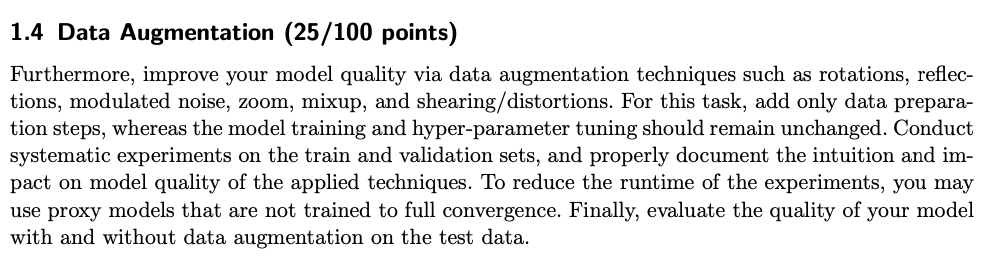

I will now write functions which provide the data augmentation functionality. Doing this before 1.3, because we can probably train with and without the augmented data immediately if we include the data augmentation functions into the pipeline.

Now for the actual sattelite data

Let's start by defining both the geometric and the other transformations

The transformation needs to take as input two images, the sattelite one, and the openstreetmap image.

In [ ]:
example_satt_image, example_osm_target = train_X[0], train_y[0]
fig = plt.figure(figsize=(10, 10), layout='tight')
fig.add_subplot(1, 2, 1)
preProcessor.plot(example_satt_image)
fig.add_subplot(1, 2, 2)
preProcessor.plot(example_osm_target)

In [ ]:
one_percent_input_size = config.patch_size // 100

max_shear = one_percent_input_size
min_crop_size = config.patch_size - one_percent_input_size * 2
max_crop_size = config.patch_size

osm_img_target_str = 'osm_img'

geometric_transformations = A.Compose([
    A.Rotate(limit=45, border_mode=cv2.BORDER_REFLECT, p=1.0),
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.Affine(shear={'x': (-max_shear, max_shear), 'y': (-max_shear, max_shear)}, p=1), # this adds the black padding. This is okay.
    A.CenterCrop(height=random.randint(min_crop_size, max_crop_size), width=random.randint(min_crop_size, max_crop_size), always_apply=True),
    A.PadIfNeeded(min_height=config.patch_size, min_width=config.patch_size, pad_height_divisor=None, pad_width_divisor=None, border_mode=cv2.BORDER_REFLECT, p=1)
],
additional_targets={osm_img_target_str: 'image'})


# ignoring mixup, I believe it to be unecessarily complex for data augmentations. Instead I am adding RandomBrightnessContrast
other_transformations = A.Compose([
    # random noise
#     A.RandomRain(slant_lower = 0, slant_upper=0, brightness_coefficient=1.0, drop_length=2, drop_width=2, drop_color = (0, 0, 0), blur_value=1, rain_type = None,p=1),
#     A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(),
])

# this one works on the sattelite and osm data.
def get_data_augmentation(sattelite_images, osm_images, geometric_transformations, other_transformations):
    augmented_satt_images = []
    augmented_osm_images = []

    image_tuples = zip(sattelite_images, osm_images)
    for sattelite_img, osm_img in image_tuples:
        sattelite_img = (sattelite_img * 255).astype(np.uint8)
        osm_img = (osm_img * 255).astype(np.uint8)
            
        
        # let's first apply the geometric augmentations
        transformed_images = geometric_transformations(image = sattelite_img, osm_img = osm_img)
        geom_sattelite_img, augmented_osm_img = transformed_images["image"], transformed_images[osm_img_target_str]
        
        augmented_sattelite_img = other_transformations(image=geom_sattelite_img)["image"]

        augmented_sattelite_img = augmented_sattelite_img / 255
        augmented_osm_img = augmented_osm_img / 255

        augmented_satt_images.append(augmented_sattelite_img)
        augmented_osm_images.append(augmented_osm_img)
        
    return np.array(augmented_satt_images), np.array(augmented_osm_images)


augmented_sattelite_images_1, augmented_osm_images_1 = get_data_augmentation(train_X, train_y, geometric_transformations, other_transformations)
augmented_sattelite_images_2, augmented_osm_images_2 = get_data_augmentation(train_X, train_y, geometric_transformations, other_transformations)
augmented_sattelite_images_3, augmented_osm_images_3 = get_data_augmentation(train_X, train_y, geometric_transformations, other_transformations)
print(augmented_osm_images_1.shape)
print(augmented_sattelite_images_1.shape)

preProcessor.plot_patches(augmented_sattelite_images_1,2,16)
preProcessor.plot_patches(augmented_osm_images_1,2,16)
preProcessor.plot_patches(augmented_sattelite_images_2,2,16)
preProcessor.plot_patches(augmented_osm_images_2,2,16)
preProcessor.plot_patches(augmented_sattelite_images_3,2,16)
preProcessor.plot_patches(augmented_osm_images_3,2,16)

augmented_X = np.concatenate((X, augmented_sattelite_images_1, augmented_sattelite_images_2, augmented_sattelite_images_3))
augmented_y = np.concatenate((y, augmented_osm_images_1, augmented_osm_images_2, augmented_osm_images_3))
print(augmented_X.shape)
print(augmented_y.shape)

In [ ]:
# Convert augmented data to PyTorch tensors
X_tensor = torch.tensor(augmented_X, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(augmented_y, dtype=torch.float32).permute(0, 3, 1, 2) 

# Create a DataLoader for augmented data
augmented_dataset = TensorDataset(X_tensor, y_tensor)
augmented_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = BaselineCNN().to(device)
# model = BaselineCNNWithDropout().to(device)
augmented_model = FullyConvolutionalNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.008)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

augmented_model = train_model(augmented_model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, patience=10)